In [25]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [26]:
tickerSymbol = 'GC=F'
data = yf.Ticker(tickerSymbol)

prices = data.history(start='2020-01-01', end='2024-05-01').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Return')

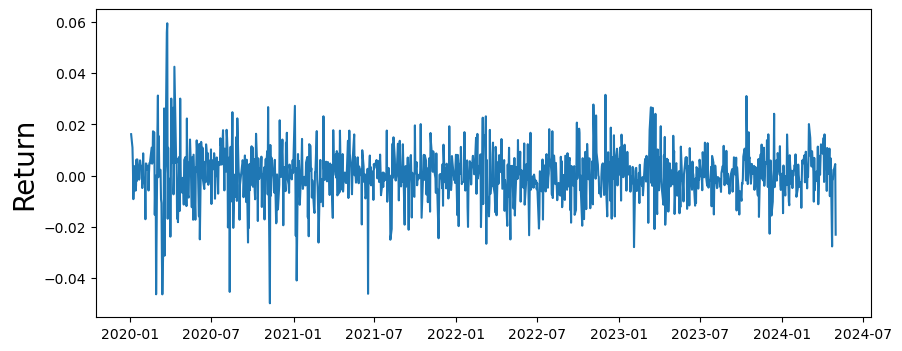

In [27]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

Text(0, 0.5, 'Price')

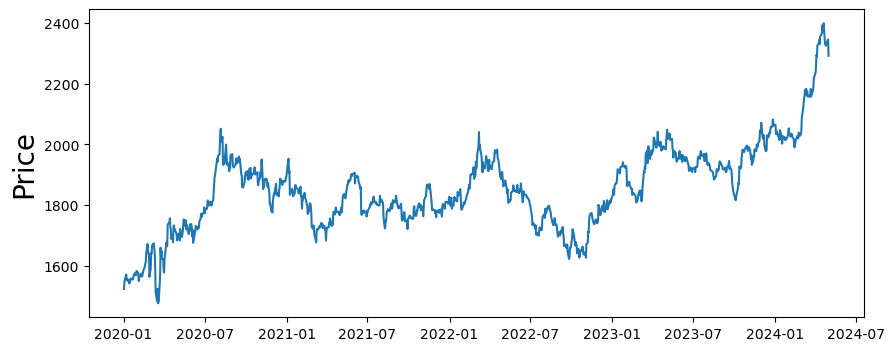

In [28]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Price', fontsize=20)

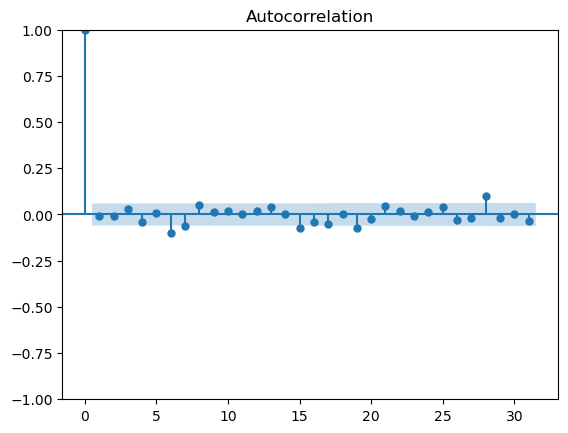

In [29]:
plot_acf(returns)
plt.show()

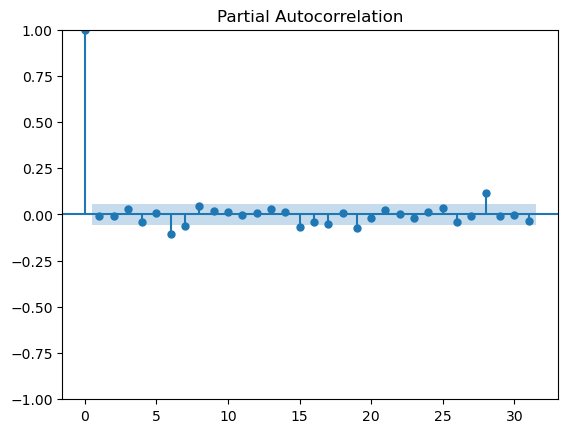

In [30]:
plot_pacf(returns)
plt.show()

In [31]:
def run_simulation(returns, prices, amount, order, thresh, verbose=True, plot=True):
    returns.index = pd.to_datetime(returns.index)

    # Rolling window size for GARCH
    window_size = 5

    curr_holding = False
    events_list = []
    init_amount = amount

    predictions = returns.copy()

    for i in tqdm(range(window_size, len(returns)), desc='Processing predictions'):
        tmrw_date = returns.index[i]
        today_date = returns.index[i-1]
        curr_data = returns.iloc[i-window_size:i]

        # ARIMA
        model = ARIMA(curr_data, order=order)
        results = model.fit()
        prediction = results.forecast(1)
        predictions.iloc[i] = prediction.iloc[0]
        
        # GARCH
        model = arch_model(curr_data, vol='Garch', p=order[0], q=order[2])
        results = model.fit(disp="off")
        prediction = results.forecast(horizon=1).mean['h.1'].iloc[-1]
        predictions.iloc[i] = prediction

        if (not curr_holding) and (prediction > thresh):
            buy_price = prices.iloc[i-1]
            curr_holding = True
            events_list.append(('b', today_date))
        elif (prediction < 0 or i == len(returns)-1) and curr_holding:
            sell_price = prices.iloc[i-1]
            ret = (sell_price - buy_price) / buy_price
            amount += ret
            curr_holding = False
            events_list.append(('s', today_date, ret))

    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(prices[14:])

        y_lims = (int(prices.min() * .95), int(prices.max() * 1.05))
        shaded_y_lims = int(prices.min() * .5), int(prices.max() * 1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'yellow' if event[2] > 0 else 'purple'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100 * (amount / init_amount - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s" % (thresh, round(amount, 2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()

    return predictions, events_list

Processing predictions:   0%|          | 0/1084 [00:00<?, ?it/s]c:\Users\jessi\anaconda3\envs\use_this_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jessi\anaconda3\envs\use_this_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\jessi\anaconda3\envs\use_this_env\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.575e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initi

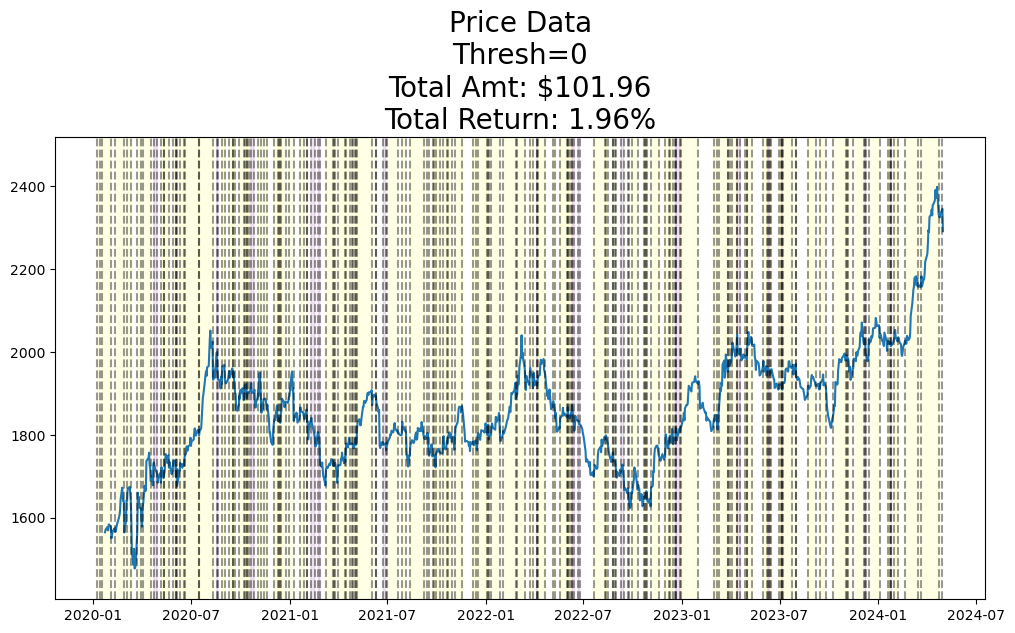

In [32]:
my_order = (1,0,1)
# my_seasonal_order = (1,0,0,28)
my_thresh = 0
amount = 100
preds, events = run_simulation(returns, prices, amount, my_order, my_thresh)

In [33]:
print(events)

[('b', Timestamp('2020-01-09 00:00:00-0500', tz='America/New_York')), ('s', Timestamp('2020-01-13 00:00:00-0500', tz='America/New_York'), 6.419390289602288e-05), ('b', Timestamp('2020-01-17 00:00:00-0500', tz='America/New_York')), ('s', Timestamp('2020-02-04 00:00:00-0500', tz='America/New_York'), 0.018205262215542285), ('b', Timestamp('2020-02-11 00:00:00-0500', tz='America/New_York')), ('s', Timestamp('2020-02-28 00:00:00-0500', tz='America/New_York'), 0.04146824846189231), ('b', Timestamp('2020-03-04 00:00:00-0500', tz='America/New_York')), ('s', Timestamp('2020-03-11 00:00:00-0400', tz='America/New_York'), 0.010352597437883783), ('b', Timestamp('2020-03-23 00:00:00-0400', tz='America/New_York')), ('s', Timestamp('2020-03-30 00:00:00-0400', tz='America/New_York'), 0.09427225364829009), ('b', Timestamp('2020-04-03 00:00:00-0400', tz='America/New_York')), ('s', Timestamp('2020-04-17 00:00:00-0400', tz='America/New_York'), 0.058251876783242555), ('b', Timestamp('2020-04-23 00:00:00-040

In [34]:
for date, pred_r in preds.items():
    acc_r = returns[date]
    print(date, "|", acc_r, "  ", pred_r)

2020-01-03 00:00:00-05:00 | 0.01620200142464734    0.01620200142464734
2020-01-06 00:00:00-05:00 | 0.010973405974574524    0.010973405974574524
2020-01-07 00:00:00-05:00 | 0.003575595601353454    0.003575595601353454
2020-01-08 00:00:00-05:00 | -0.009161486173001832    -0.009161486173001832
2020-01-09 00:00:00-05:00 | -0.0036599930350791343    -0.0036599930350791343
2020-01-10 00:00:00-05:00 | 0.0037378675070167677    0.0030826699066678577
2020-01-13 00:00:00-05:00 | -0.005842680954052937    0.0010406053688522142
2020-01-14 00:00:00-05:00 | -0.0038749676475047234    -0.0022701394107527357
2020-01-15 00:00:00-05:00 | 0.0062888686581550335    -0.003711586337400585
2020-01-16 00:00:00-05:00 | -0.001997278290509108    -0.0007825958303387989
2020-01-17 00:00:00-05:00 | 0.006326693885167822    -0.00032377785792544615
2020-01-21 00:00:00-05:00 | -0.001539661495306488    0.000192912064397702
2020-01-22 00:00:00-05:00 | -0.000706743490544226    0.0010680923453672546
2020-01-23 00:00:00-05:00 | 

Text(0, 0.5, 'Return')

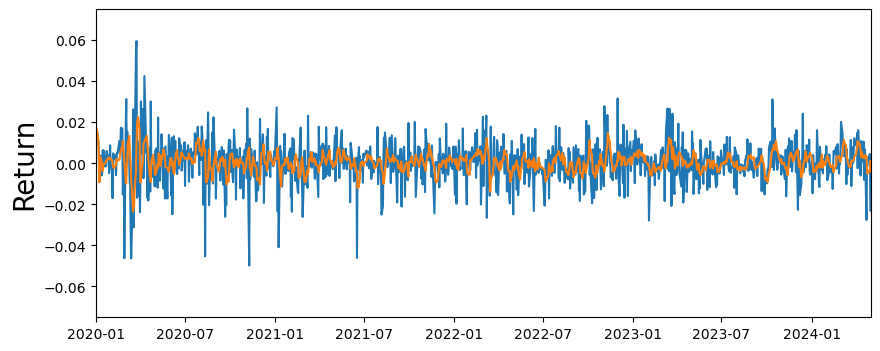

In [35]:
start_date = pd.to_datetime('2020-01-01 00:00:00-05:00')
end_date = pd.to_datetime('2024-05-01 00:00:00-05:00')

plt.figure(figsize=(10,4))
plt.xlim(start_date, end_date)
plt.ylim(-0.075, 0.075)
plt.plot(returns)
plt.plot(preds)
plt.ylabel('Return', fontsize=20)